<a href="https://colab.research.google.com/github/balsrini/Assignment10/blob/master/Kernels_and_Activations_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRADCAM - Last layer and last -1 layer

Let's start with a pretrained VGG model

In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [7]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [26]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

180


1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values
4. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14
5. Normalize the heat map to make the values between 0 and 1

In [0]:
import keras.backend as K
def showHeatMap(class_output,last_conv_layer1) :
  grads = K.gradients(class_output, last_conv_layer1.output)[0]  
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  
  iterate = K.function([model.input], [pooled_grads, last_conv_layer1.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  print(conv_layer_output_value.shape)
  print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
  from google.colab.patches import cv2_imshow
  cv2_imshow( dog)
  cv2_imshow(superimposed_img)
  return

1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

Tensor("strided_slice_3:0", shape=(?,), dtype=float32)
(14, 14, 512)
(14, 14)


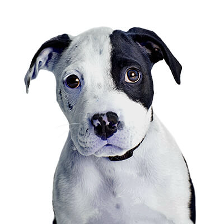

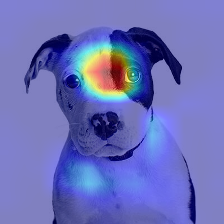

(14, 14, 512)
(14, 14)


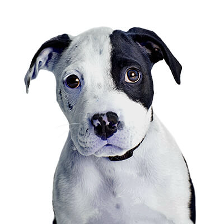

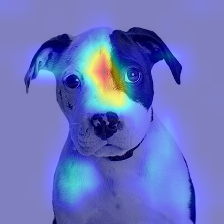

In [32]:
print(class_output)
print(model.get_layer("block5_conv3"))
showHeatMap(class_output,model.get_layer("block5_conv3"))
#Showing one layer before
showHeatMap(class_output,model.get_layer("block5_conv2"))

Show the results

In [13]:
!pip install keract

('n02124075', 'Egyptian_cat', 0.47480357)
Egyptian_cat (47.48035669326782)
input_4:0 (224, 224, 3) -> Skipped. First dimension is not 1.
block1_conv1_3/Relu:0 (1, 224, 224, 64) 


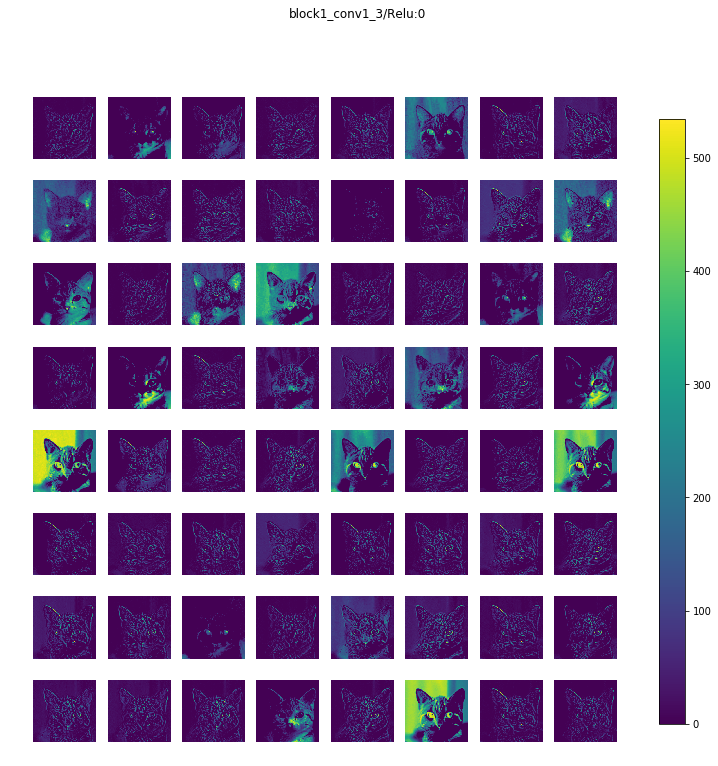

block1_conv2_3/Relu:0 (1, 224, 224, 64) 


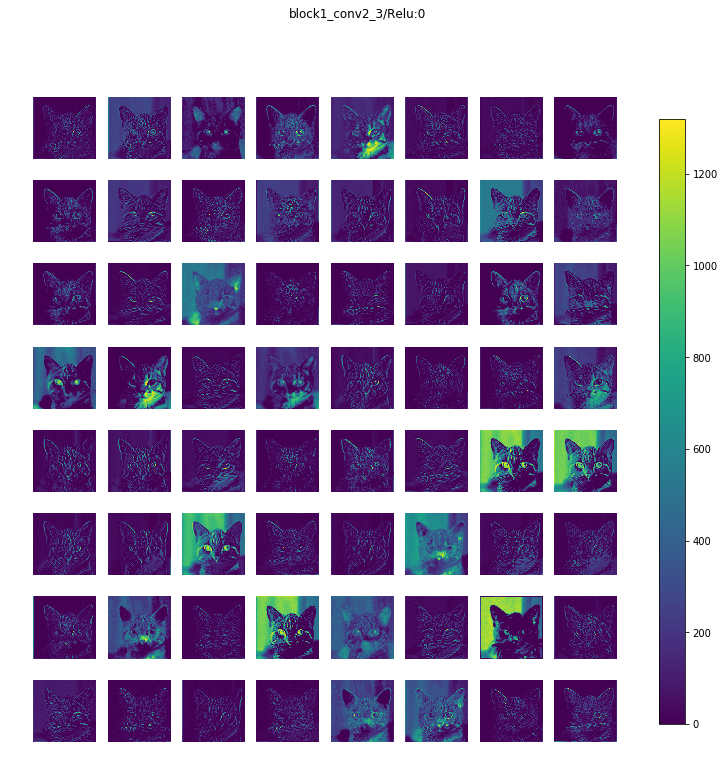

block1_pool_3/MaxPool:0 (1, 112, 112, 64) 


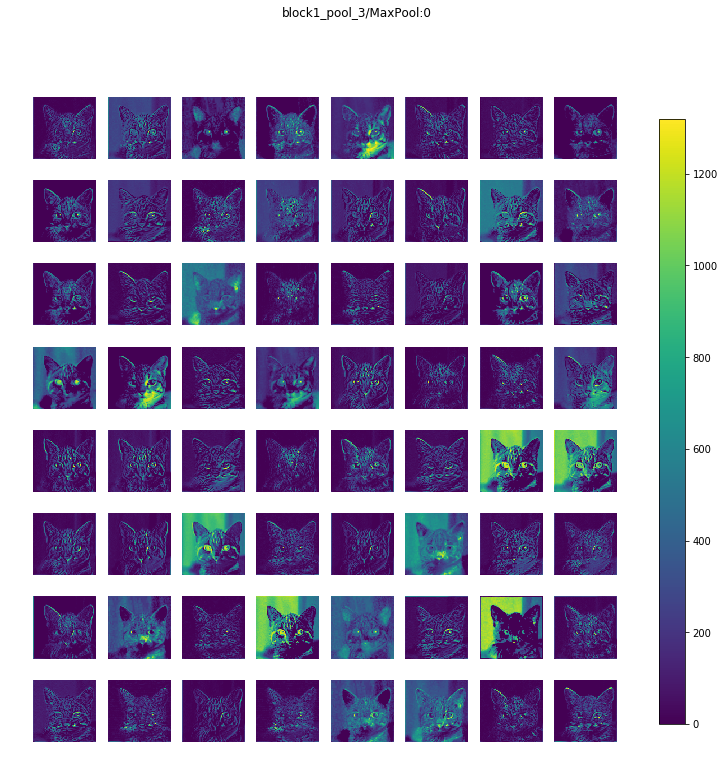

block2_conv1_3/Relu:0 (1, 112, 112, 128) 


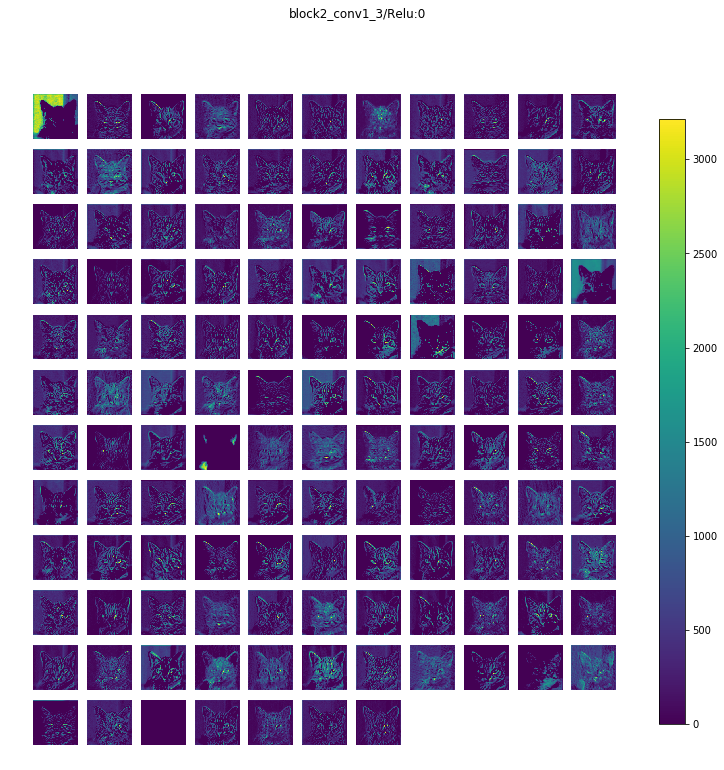

block2_conv2_3/Relu:0 (1, 112, 112, 128) 


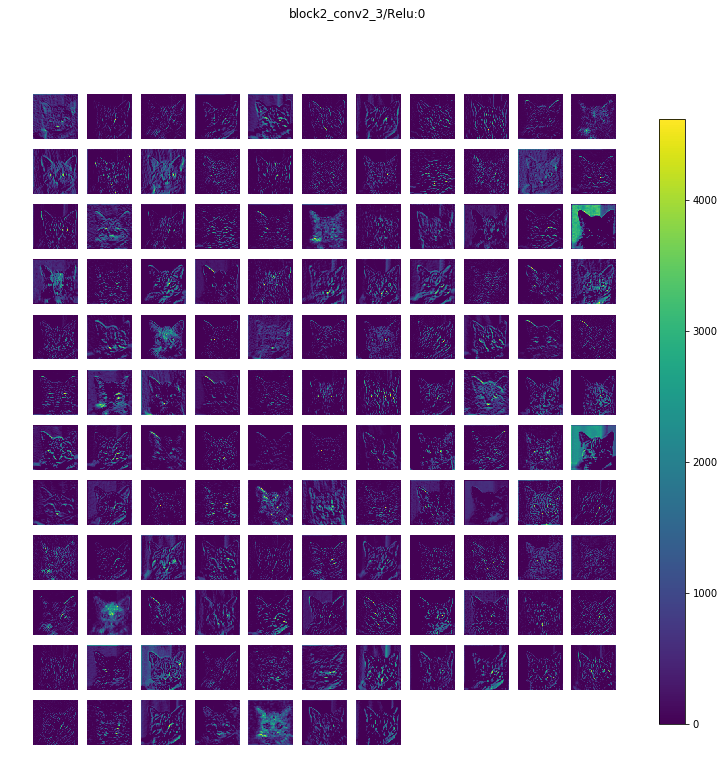

block2_pool_3/MaxPool:0 (1, 56, 56, 128) 


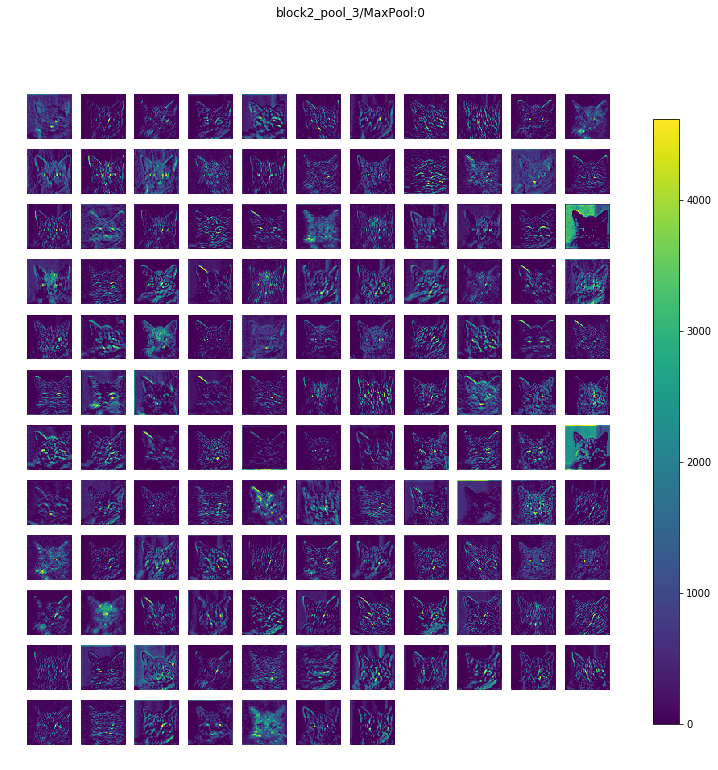

block3_conv1_3/Relu:0 (1, 56, 56, 256) 


In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

model = VGG16()

from PIL import Image
import requests
from io import BytesIO

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Gatto_europeo4.jpg/250px-Gatto_europeo4.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image = image.crop((0, 0, 224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
yhat = model.predict(image)
label = decode_predictions(yhat)
label = label[0][0]
print(label)
print('{} ({})'.format(label[1], label[2] * 100))

import keract

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
activations = keract.get_activations(model, image)
first = activations.get('block1_conv1/Relu:0')
keract.display_activations(activations)